# Detailed Balance Efficiency Limit
import necessary packagaes

In [2]:
%config InlineBackend.figure_format = 'retina' #to make inline images higher res

from math import pi
from scipy.integrate import trapz
from scipy.interpolate import interp1d
import scipy.io

import numpy as np
import matplotlib.pyplot as plt

define plot style

In [11]:
plt.style.use(['presplot'])

initialize constants, load data

In [12]:
#constants
c=2.998e8 #m/s
h=4.136e-15 #eV s
hbar=h/(2*np.pi)
k=8.617e-5 #eV/K
q=1.602e-19 #C
t_c=300
t_s=5800
omega_s=6.8e-5
omega_c=pi

#bandgaps
e_step=0.001 #step size for bandgaps 
egs=np.arange(e_step,3,e_step) #bandgaps in eV

#am1.5 data
am1p5_raw=np.loadtxt("am1p5_raw.txt")

### SQ limit, AM0

calculate incident power and initialize efficiency array

In [13]:
#incident power
e_tot=np.arange(e_step,8,e_step)
bbe_s=2*omega_s/(h**3*c**2)*e_tot**3/(np.exp(e_tot/(k*t_s))-1)
bbe_c=2*omega_c/(h**3*c**2)*e_tot**3/(np.exp(e_tot/(k*t_c))-1)
pinc_am0=q*trapz(bbe_s,e_tot) #W/(m^2) - multiply by q for eV to J

#initialize efficiency
eff_am0=np.zeros(len(egs))
jsc_am0=np.zeros(len(egs))
voc_am0=np.zeros(len(egs))

run over bandgaps, find max efficiency

In [14]:
i=0 #initialize index

for eg in egs:
    
    e=np.arange(eg,8,e_step) #integration bounds are e_g to infinity (8 ev here)
    v=np.arange(0,eg,e_step) #voltages from from 0 to bandgap
    
    bb_c=2*omega_c/(h**3*c**2)*e**2/(np.exp(e/(k*t_c))-1) #bb radiation from cell, photons/(m^2*s)
    j0=q*trapz(bb_c,e) #C/(m^2*s) = A/m^2
    
    bb_s=2*omega_s/(h**3*c**2)*e**2/(np.exp(e/(k*t_s))-1) #bb radiation from sun, photons/(m^2*s)
    jsc=q*trapz(bb_s,e) #C/(m^2*s) = A/m^2
    jsc_am0[i]=jsc
    
    j=-(j0*(np.exp(v/(k*t_c))-1)-jsc) #just need v b/c k is in eV/K
    #j=-(j0*(np.exp(v/(k*T_c)))-jsc) #no real difference
    
    voc=k*t_c*np.log(jsc/j0+1)
    voc_am0[i]=voc
    
    pmax=np.max(j*v)
    eff_am0[i]=pmax/pinc_am0
    
    i+=1 #index
    

### SQ limit, AM1.5
calculate incident power and initialize efficiency array

In [15]:
#incident power
ev=1240/am1p5_raw[::-1,0]
am1p5=1/ev**2*1240*am1p5_raw[::-1,1] #W/(m^2 eV)
pinc_am1p5=trapz(am1p5,ev)

#create interpolant
g=interp1d(ev,am1p5,fill_value="extrapolate")

#initialize efficiency
eff_am1p5=np.zeros(len(egs))
jsc_am1p5=np.zeros(len(egs))
voc_am1p5=np.zeros(len(egs))

run over bandgaps, find max efficiency

In [16]:
i=0 #initialize index

for eg in egs:
    
    e=np.arange(eg,5,e_step) #integration bounds are e_g to infinity (8 ev here)
    v=np.arange(0,eg,e_step) #voltages from from 0 to bandgap
    
    bb_c=2*omega_c/(h**3*c**2)*e**2/(np.exp(e/(k*t_c))-1) #bb radiation from cell, photons/(m^2*s)
    j0=q*trapz(bb_c,e) #C/(m^2*s) = A/m^2
    
    rad_s=g(e)/(q*e) #solar spectrum radiation from sun, photons/(m^2*s)
    jsc=q*trapz(rad_s,e) #C/(m^2*s) = A/m^2
    jsc_am1p5[i]=jsc
    
    j=-(j0*(np.exp(v/(k*t_c))-1)-jsc) #just need v b/c k is in eV/K
    #j=-(j0*(np.exp(v/(k*t_c)))-jsc) #no real difference
    
    voc=k*t_c*np.log(jsc/j0+1)
    voc_am1p5[i]=voc
    
    pmax=np.max(j*v)
    eff_am1p5[i]=pmax/pinc_am1p5

    if eg==1.337: #save I-V data for best device 1.337
        jmax=j
        vmax=v
    
    i+=1 #index
    

find voc, jsc, etc.

In [17]:
temp=vmax[np.absolute(jmax)==np.min(np.absolute(jmax))]
voc=temp[0]
temp=jmax[np.absolute(vmax)==np.min(np.absolute(vmax))]
jsc=round(temp[0],3)
pce=np.max(jmax*vmax)/pinc_am1p5
ff=np.max(jmax*vmax)/(voc*jsc)

### Plots 

plot S-Q efficiency limit

(0, 0.36)

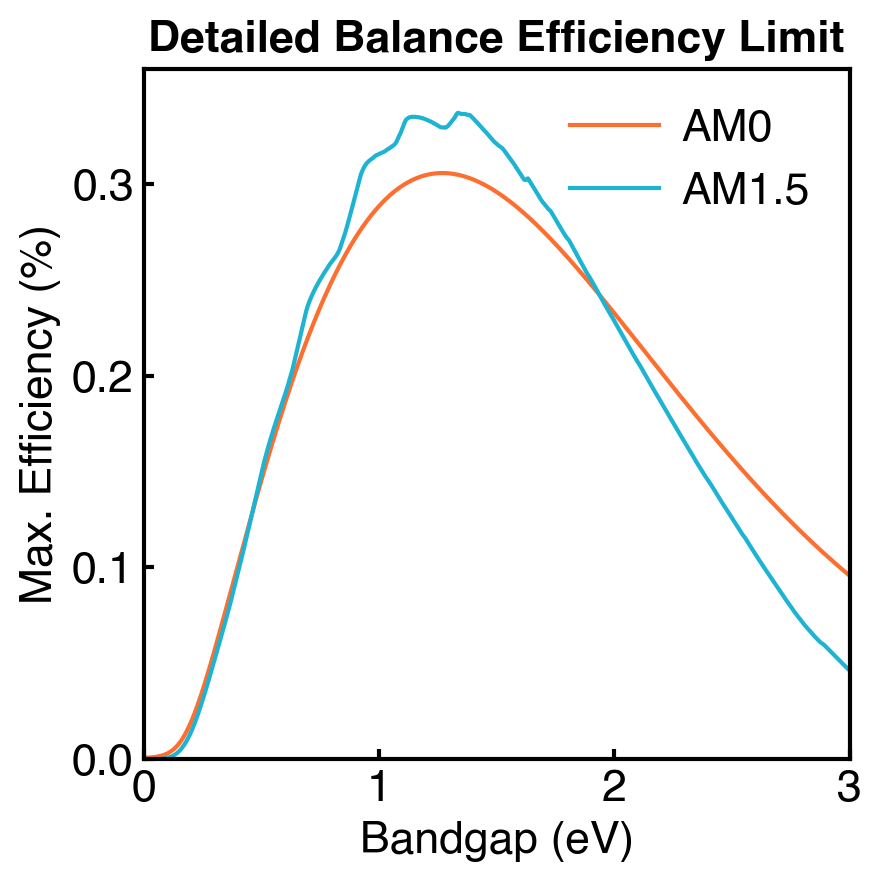

In [18]:
fig,ax=plt.subplots()
ax.plot(egs,eff_am0,label='AM0')
ax.plot(egs,eff_am1p5,label='AM1.5')
ax.set_xlabel("Bandgap (eV)")
ax.set_ylabel("Max. Efficiency (%)")
ax.legend(loc="upper right")
ax.set_title('Detailed Balance Efficiency Limit')
ax.set_xlim([0,3])
ax.set_ylim([0,0.36])
#fig.savefig('sqlimit')

plot illumination spectra

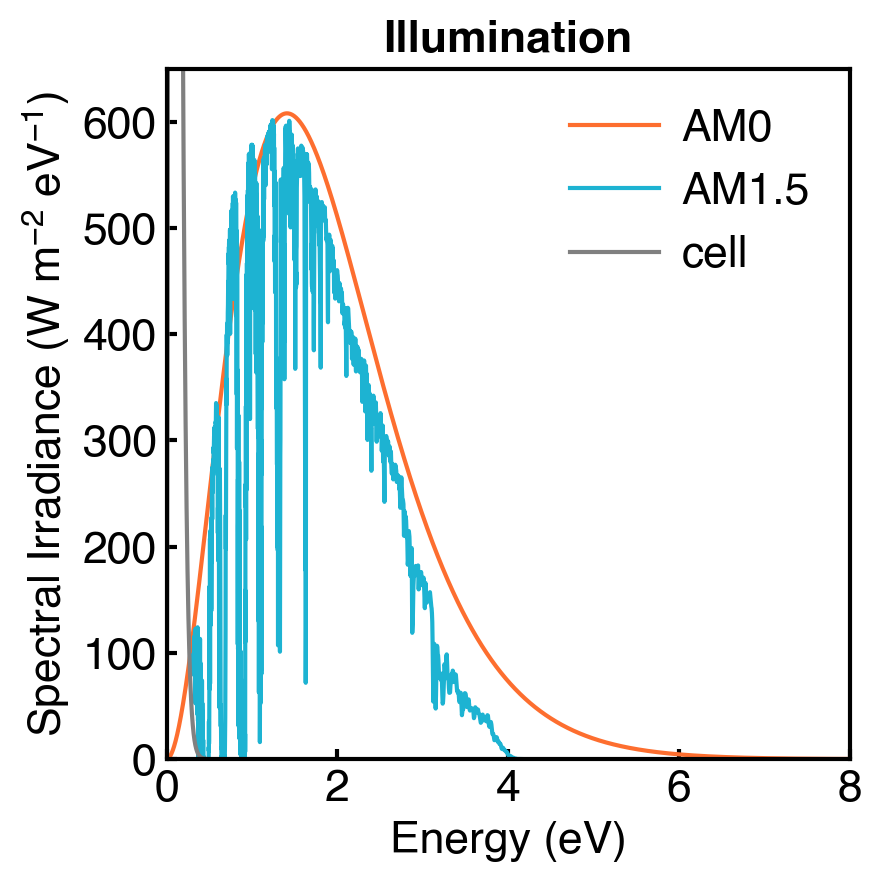

In [11]:
fig,ax=plt.subplots()
ax.plot(e_tot,bbe_s*q,label='AM0')
ax.plot(ev,am1p5,label='AM1.5')
ax.plot(e_tot,bbe_c*q,label='cell')
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Spectral Irradiance (W $m^{-2}$ $eV^{-1}$)")
ax.legend(loc="upper right")
ax.set_title('Illumination')
ax.set_xlim([0,8])
ax.set_ylim([0,650]);

plot I-V curve for best solar cell

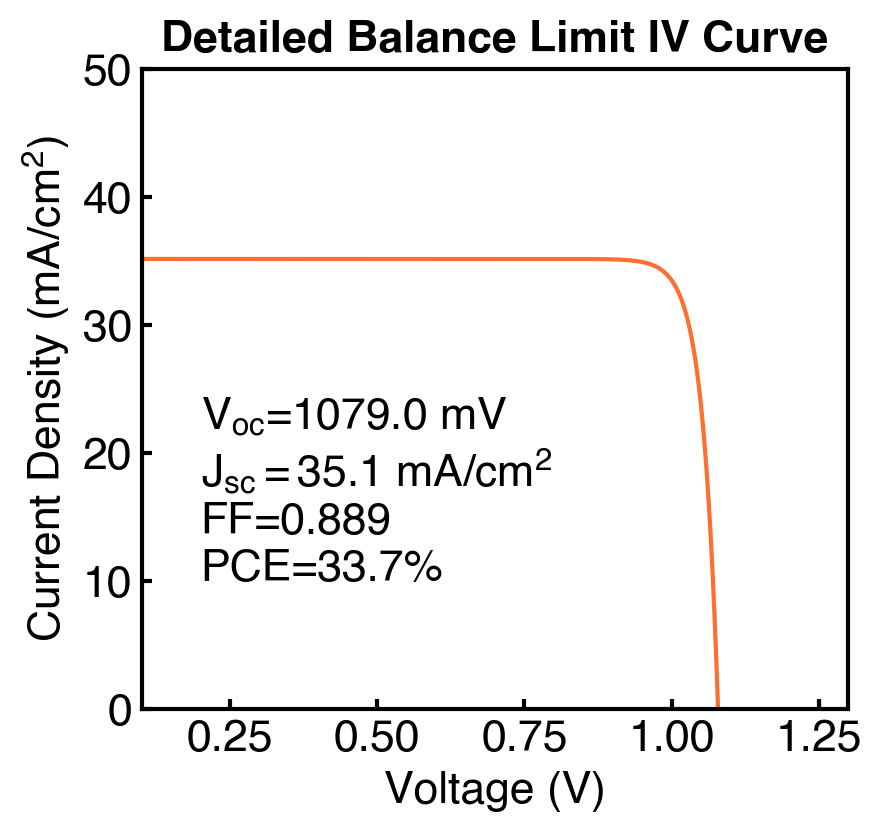

In [12]:
fig,ax=plt.subplots(figsize=[4.25,4])
ax.plot(vmax,jmax/10)
ax.set_xlabel("Voltage (V)")
ax.set_ylabel("Current Density ($mA/cm^2$)")
ax.set_title('Detailed Balance Limit IV Curve')
ax.set_xlim([0.1,1.3]);
ax.set_ylim([0,50]);

ivdata = '$V_{oc}$='+str(voc*1000)+' mV\n$J_{sc}=$'+str(round(jsc/10.0,1))+' $mA/cm^2$'\
    '\nFF='+ str(round(ff,3))+'\nPCE='+str(round(pce*100,1))+'%'
ax.text(0.2,10,ivdata);
fig.savefig('idealIV')

current

(0, 100)

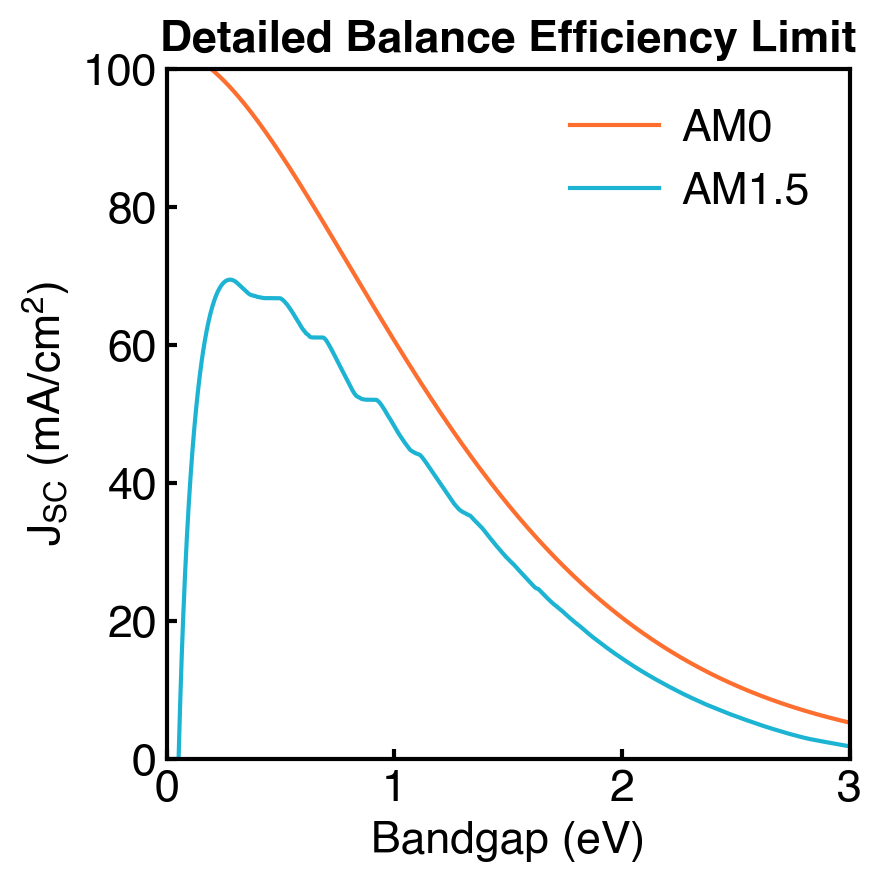

In [13]:
fig,ax=plt.subplots()
ax.plot(egs,jsc_am0*0.1,label='AM0')
ax.plot(egs,jsc_am1p5*0.1,label='AM1.5')
ax.set_xlabel("Bandgap (eV)")
ax.set_ylabel("$J_{SC}$ ($mA/cm^2$)")
ax.legend(loc="upper right")
ax.set_title('Detailed Balance Efficiency Limit')
ax.set_xlim([0,3])
ax.set_ylim([0,100])
#fig.savefig('sqlimit')

voltage

(0, 3)

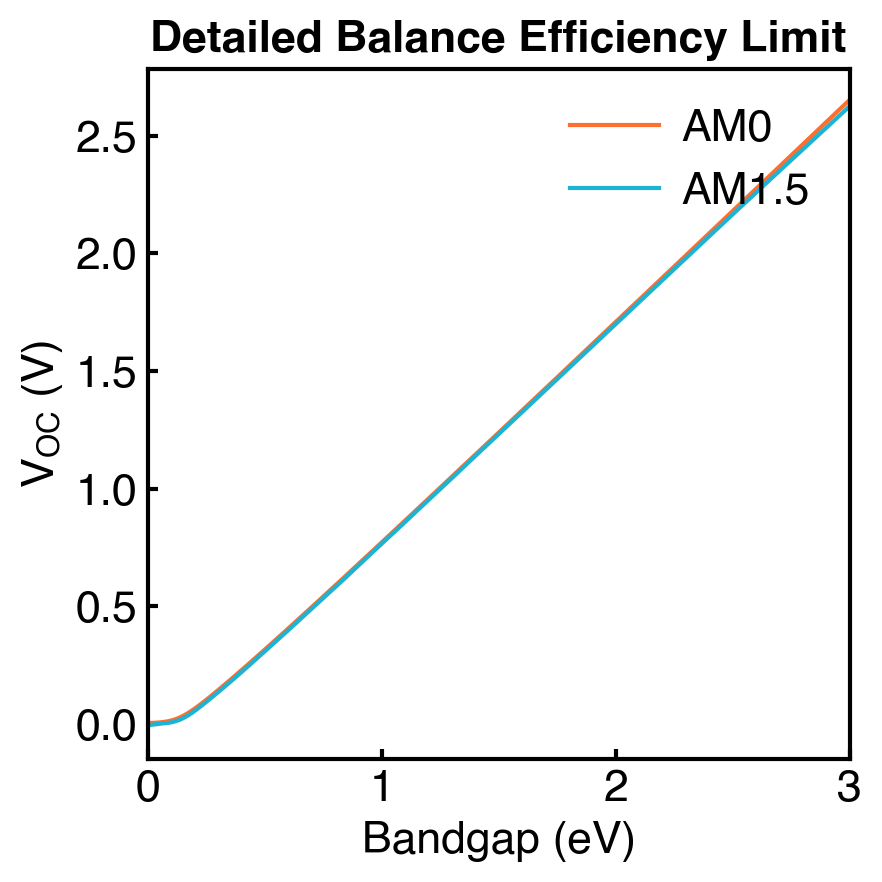

In [14]:
fig,ax=plt.subplots()
ax.plot(egs,voc_am0,label='AM0')
ax.plot(egs,voc_am1p5,label='AM1.5')
ax.set_xlabel("Bandgap (eV)")
ax.set_ylabel("$V_{OC}$ (V)")
ax.legend(loc="upper right")
ax.set_title('Detailed Balance Efficiency Limit')
ax.set_xlim([0,3])
#ax.set_ylim([0,100])
#fig.savefig('sqlimit')

figure out other material constants for an ideal solar cell

In [15]:
eg=1.34
t=t_c

m0=9.109e-31; #kg
mh=1*m0
me=1*m0

Nc=2*(me*k*t/(2*np.pi*hbar**2*q))**(3/2)*1/(100**3) #1/cm^3
Nv=2*(mh*k*t/(2*np.pi*hbar**2*q))**(3/2)*1/(100**3) #1/cm^3
ni=(Nc*Nv)**0.5*np.exp(-eg/(2*k*t))

#assume total absorption above the bandgap
e=np.arange(eg,8,e_step) #integration bounds are e_g to infinity (8 ev here)
bb_c=2*omega_c/(h**3*c**2)*e**2/(np.exp(e/(k*t_c))-1)
r=trapz(bb_c,e) #photons/m^2/s
r*=1e-4/10e-4 #1/m^2 to 1/cm^2, then divide by thickness in cm
br=r/ni**2 #cm^3/s
tau=1/(2*ni*br)

#generation rate
rad_s=g(e)/(q*e) #solar spectrum radiation from sun, photons/(m^2*s)
gen=trapz(rad_s,e) #photons/m^2/s
g_cm2=gen*1e-4
g_cm3=g_cm2/10e-4 #1/m^2 to 1/cm^2, then divide by thickness in cm

#max QFLS
qfls=eg-k*t*np.log(Nc*Nv*br/g_cm3)

#outputs
[g_cm2,g_cm3,r,br,ni,tau,qfls]

[2.1868935131118566e+17,
 2.1868935131118567e+20,
 146.68469945004242,
 7.573412737152525e-15,
 139170310.05799717,
 474385.9127086241,
 1.0817583228488368]

TMD IV curve

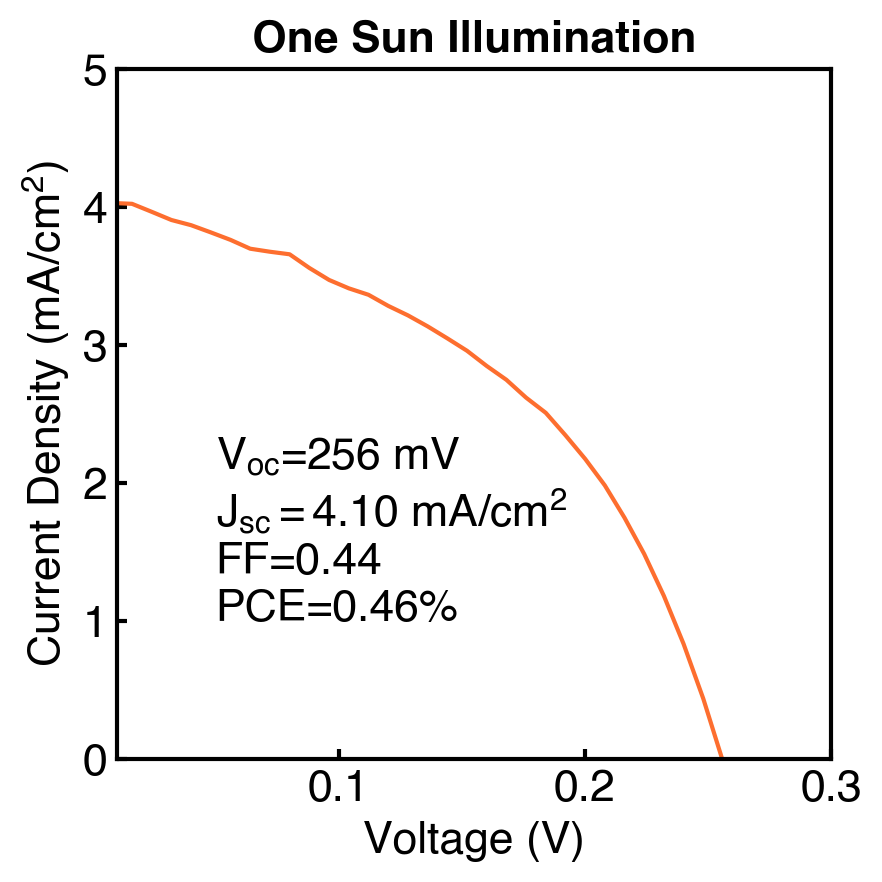

In [16]:
onesun_raw = scipy.io.loadmat('onesun_final.mat')
onesun=onesun_raw['onesun_final']
onesun

fig,ax=plt.subplots()
ax.plot(onesun[:,0],onesun[:,1])
ax.set_xlabel("Voltage (V)")
ax.set_ylabel("Current Density ($mA/cm^2$)")
ax.set_title('One Sun Illumination')
ax.set_xlim([0.01,0.3])
ax.set_ylim([0,5])

ivdata = '$V_{oc}$=256 mV\n$J_{sc}=$4.10 $mA/cm^2$'\
    '\nFF=0.44\nPCE=0.46%'
ax.text(0.05,1,ivdata);
fig.savefig('tmdIV')